# Applying the models in a validation set  
## How it works
The models have already been trained and serialized (saved) to a pickle file. They are loaded and receive as input the activity data and values of molecular descriptors for a set of compounds. Finally, the models predict the activity of these compounds based on the data they have been previously trained on. 

## Table of contents
1. [Read data](#read)
2. [Classifiers and molecular descriptors](#classifiers)
3. [Confusion matrices](#confusion)
4. [ROC curves](#roc)    
5. [Class distribution](#class)    
6. [Spearman correlations](#spearman)    
7. [Error metrics](#error)    

<a id='read'></a>
## Read data

In [1]:
# File containing the compounds and their molecular descriptors
files = '../files'
compounds = files + '/test_data.csv'

In [2]:
import pandas as pd

activity = pd.read_csv(f'{files}/activity_data.csv')
test_data = pd.read_csv(compounds)
test_data.head()

,CID,f_activity,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,LON-WEI-4d77710c-1,0,12.398116,-0.385486,12.398116,0.113264,0.726527,367.405,346.237,367.153206,...,0,0,0,0,0,0,0,0,0,1
1,LON-WEI-4d77710c-2,1,14.078683,-4.475363,14.078683,0.157138,0.409644,475.494,460.374,475.035971,...,0,0,2,0,0,0,0,0,0,0
2,LON-WEI-4d77710c-4,0,12.697956,-0.361618,12.697956,0.049503,0.586838,428.330,406.154,427.089539,...,0,0,0,0,0,0,0,0,0,1
3,LON-WEI-4d77710c-5,0,12.394200,-0.429609,12.394200,0.119029,0.754619,353.378,334.226,353.137556,...,0,0,0,0,0,0,0,0,0,1
4,LON-WEI-4d77710c-6,0,12.308397,-0.454163,12.308397,0.075823,0.720096,335.363,318.227,335.126991,...,0,0,0,0,0,0,0,0,0,1


<a id='classifiers'></a>
## Classifiers and molecular descriptors

In [3]:
def load_pickle(model_name):
    import pickle
    file = open(f'../pickle/{model_name}.pickle', 'rb')
    model_fitted = pickle.load(file)
    file.close()
    return model_fitted

In [4]:
activity_label = 'f_activity'
top_models = ['RandomForestClassifier', 'KNeighborsClassifier', 'XGBClassifier']
descriptors = ['NumAliphaticCarbocycles', 'TPSA', 'fr_urea', 'NumHDonors', 'fr_NH2', 'NumHAcceptors']

<a id='confusion'></a>
## Confusion matrices

In [5]:
def print_confusion_matrix(y_test, y_pred):
    from sklearn.metrics import confusion_matrix  
    conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
    matrix = pd.DataFrame(conf_matrix)
    print(matrix.round(2))

In [6]:
y_test = test_data[activity_label]
Y = pd.DataFrame(test_data['CID'])
probas = pd.DataFrame(test_data['CID'])

for model_name in top_models:
    model_fitted = load_pickle(model_name)
    
    X_test = test_data[descriptors]
    y_pred = model_fitted.predict(X_test)
    Y[model_name] = y_pred
    
    print('\n', model_name)
    print_confusion_matrix(y_test, y_pred)
    
    y_proba = model_fitted.predict_proba(X_test)
    probas[model_name] = y_proba[:,1]


 RandomForestClassifier
      0     1
0  0.94  0.06
1  0.62  0.38

 KNeighborsClassifier
      0     1
0  0.91  0.09
1  0.54  0.46

 XGBClassifier
      0     1
0  0.96  0.04
1  0.75  0.25


In [57]:
y_test = test_data[activity_label]
Y = pd.DataFrame(test_data['CID'])
probas = pd.DataFrame(test_data['CID'])

for model_name in top_models:
    model_fitted = load_pickle(model_name)
    
    X_test = test_data[descriptors]
    y_pred = model_fitted.predict(X_test)
    Y[model_name] = y_pred
    
    print('\n', model_name)
    print_confusion_matrix(y_test, y_pred)
    
    y_proba = model_fitted.predict_proba(X_test)
    probas[model_name] = y_proba[:,1]


 RandomForestClassifier
      0     1
0  0.64  0.36
1  0.38  0.62

 KNeighborsClassifier
      0     1
0  0.80  0.20
1  0.46  0.54

 XGBClassifier
      0     1
0  0.86  0.14
1  0.15  0.85


<a id='roc'></a>
## ROC curves

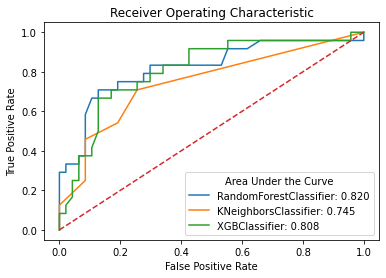

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import roc_curve, auc

for model_name in top_models:
    y_proba = probas[model_name]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{model_name}: {auc(fpr, tpr):>.3f}')

plt.plot([0,1], [0,1], linestyle='--')
plt.legend(title='Area Under the Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.savefig('figures/new_roc_curve.png')
plt.show()

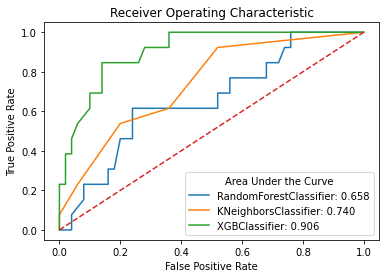

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import roc_curve, auc

for model_name in top_models:
    y_proba = probas[model_name]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{model_name}: {auc(fpr, tpr):>.3f}')

plt.plot([0,1], [0,1], linestyle='--')
plt.legend(title='Area Under the Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

<a id='class'></a>
## Class distribution

In [8]:
def percentage_dist(values):
    values = pd.Series(values, name='values')
    distribution = values.value_counts(
        normalize=True).mul(100).reset_index().rename({'values':'Percentage','index':'Class'}, axis=1)
    return distribution

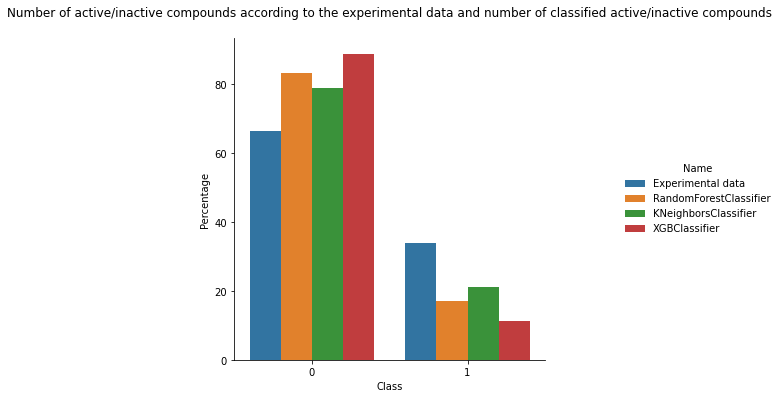

In [9]:
perc = percentage_dist(test_data[activity_label])
perc['Name'] = 'Experimental data'

for model_name in top_models:
    y_pred = Y[model_name]
    dist = percentage_dist(y_pred)
    dist['Name'] = model_name
    perc = perc.append(dist)

sns.catplot(kind='bar', data=perc, x='Class', y='Percentage', hue='Name')
plt.title('Number of active/inactive compounds according to the experimental data and number of classified active/inactive compounds', y=1.05)
plt.show()

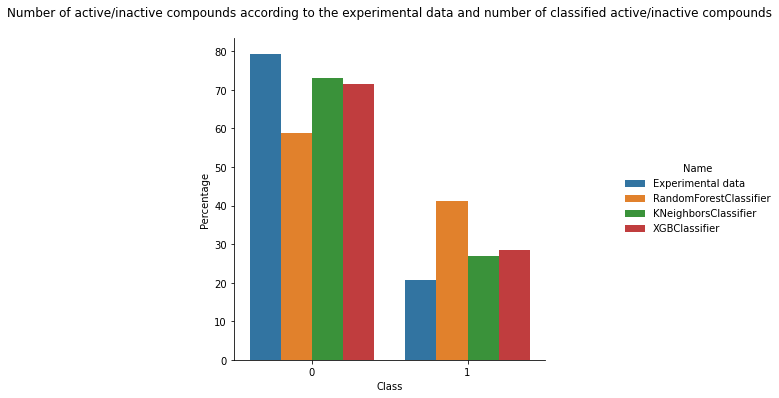

In [60]:
perc = percentage_dist(test_data[activity_label])
perc['Name'] = 'Experimental data'

for model_name in top_models:
    y_pred = Y[model_name]
    dist = percentage_dist(y_pred)
    dist['Name'] = model_name
    perc = perc.append(dist)

sns.catplot(kind='bar', data=perc, x='Class', y='Percentage', hue='Name')
plt.title('Number of active/inactive compounds according to the experimental data and number of classified active/inactive compounds', y=1.05)
plt.show()

<a id='spearman'></a>
## Spearman correlations

In [49]:
from scipy.stats import spearmanr

df = pd.merge(activity[['CID', 'f_inhibition_at_50_uM']], probas, on=['CID'])
print('Spearman R')
for model_name in top_models:
    print(f'{model_name}: {spearmanr(df[model_name], df["f_inhibition_at_50_uM"])[1]:.2f}')

Spearman R
RandomForestClassifier: 0.00
KNeighborsClassifier: 0.00
XGBClassifier: 0.00


<a id='error'></a>
## Error metrics

In [10]:
def error_metrics(y_test, y_proba):
    import numpy as np
    from sklearn.metrics import log_loss
    
    rmse = np.linalg.norm(y_proba - y_test) / np.sqrt(len(y_test))
    logl = log_loss(y_test, y_proba)
    return rmse, logl
    print('{:.4f}'.format())

In [11]:
print('{:20s}\t{:5s}\t{:5s}'.format('Model', 'RMSE', 'log_loss'))
for model_name in top_models:
    rmse, logl = error_metrics(y_test, probas[model_name])
    print(f'{model_name:20s}\t{rmse:.4f}\t{logl:.4f}')

Model               	RMSE 	log_loss
RandomForestClassifier	0.4153	0.5262
KNeighborsClassifier	0.4547	3.7032
XGBClassifier       	0.4803	0.8047


In [12]:
y_test.value_counts()

0    47
1    24
Name: f_activity, dtype: int64

In [13]:
for clf in top_models:
    print(Y[clf].value_counts())

0    59
1    12
Name: RandomForestClassifier, dtype: int64
0    56
1    15
Name: KNeighborsClassifier, dtype: int64
0    63
1     8
Name: XGBClassifier, dtype: int64
